# *Import Libary*

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage import io, img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, warp, rotate
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import os
from google.colab import drive, files
import shutil
from PIL import Image
from collections import Counter
import random
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import confusion_matrix, classification_report


# *Connect Google Drive*

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# *Upload kaggle API & Set up*

In [ ]:
# Upload file kaggle.json
files.upload()

In [ ]:
# Buat folder ~/.kaggle jika belum ada
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Pindahkan file kaggle.json yang di-upload ke folder tersebut
!cp kaggle.json ~/.kaggle/

# Ubah permission
!chmod 600 ~/.kaggle/kaggle.json

# *Download Dataset dan Simpan di Google Drive*

In [ ]:
# Slug dataset
dataset_slug = 'agungmrf/indonesian-sign-language-bisindo'
dataset_name = dataset_slug.split('/')[-1]

# Path Drive tempat simpan dataset
drive_path = f'/content/drive/MyDrive/datasets-capstone/{dataset_name}'
zip_path = os.path.join(drive_path, f'{dataset_name}.zip')

# File zip akan mengekstrak folder "plant_leaf_dataset'
extract_path = os.path.join(drive_path, 'bisindo')

# Buat folder penyimpanan jika belum ada
os.makedirs(drive_path, exist_ok=True)

# Download dan unzip hanya jika belum ada hasil ekstraknya
if not os.path.exists(extract_path):
    print("Mengunduh dari Kaggle...")
    !kaggle datasets download -d {dataset_slug} -p "{drive_path}"

    print("Mengekstrak dataset...")
    !unzip -q "{zip_path}" -d "{drive_path}"
    print("Dataset tersimpan di Google Drive.")
else:
    print("Dataset sudah tersedia di Google Drive.")

"""
Sel ini tidak perlu dijalankan jika sebelumnya sudah pernah di jalankan
"""

Mengunduh dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
 98% 1.34G/1.36G [00:08<00:00, 200MB/s]
100% 1.36G/1.36G [00:08<00:00, 170MB/s]
Mengekstrak dataset...
Dataset tersimpan di Google Drive.


'\nSel ini tidak perlu dijalankan jika sebelumnya sudah pernah di jalankan\n'

# *Upload Dataset ke Lingkungan Colab*

In [ ]:
# Path asal (data asli di Google Drive)
source_dir = '/content/drive/MyDrive/datasets-capstone/indonesian-sign-language-bisindo/bisindo/images/train'

# Path tujuan di Colab
target_dir = '/content/bisindo'

# Hapus folder target jika sebelumnya sudah ada
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Salin seluruh isi folder
shutil.copytree(source_dir, target_dir)

print(f"Dataset telah disalin ke: {target_dir}")


Dataset telah disalin ke: /content/bisindo


# *Menampilkan Daftar Kelas*

In [ ]:
# Mentampilkan beberapa folder (kelas)
print("Kelas yang tersedia:")
print(os.listdir(target_dir))

Kelas yang tersedia:
['E', 'O', 'N', 'J', 'V', 'B', 'I', 'U', 'C', 'Y', 'P', 'G', 'R', 'W', 'H', 'L', 'Z', 'M', 'A', 'F', 'S', 'X', 'D', 'T', 'Q', 'K']


# *Menampilkan Sample dari setiap Kelas*

In [ ]:
# Path dataset
dataset_path = '/content/bisindo'

# Mnyimpan list nama gambar untuk setiap kelas
letters_images = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        letters_images[class_name] = os.listdir(class_dir)

# Jumlah gambar yang ingin ditamplkan perkelas
num_images = 5

# Ukuran plot
fig, axs = plt.subplots(len(letters_images), num_images, figsize=(num_images * 3, len(letters_images) * 3))

for i, class_name in enumerate(sorted(letters_images.keys())):

    images = np.random.choice(letters_images[class_name], num_images, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")

        axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name if j == 0 else "")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()


# *Melihat Distribusi data seriap Kelas*

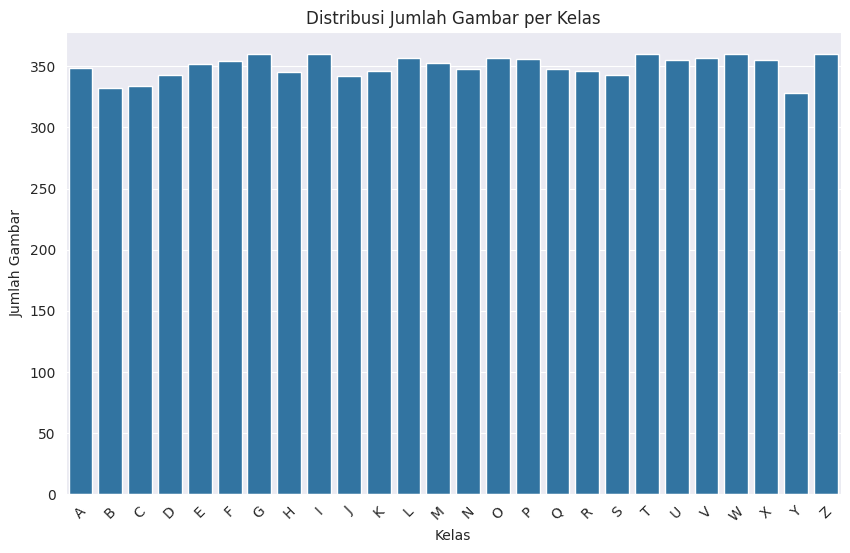

In [ ]:
# List untuk simpan nama file, path lengkap, dan label kelas
file_name = []
labels = []
full_path = []

# Kumpulkan data
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x='labels', order=sorted(distribution_df['labels'].unique()))
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()


In [ ]:
labels = []

for path, subdirs, files in os.walk(dataset_path):
    label = os.path.basename(path)
    if files:
        labels.extend([label] * len(files))

# Hitung jumlah file tiap kelas
count_per_class = Counter(labels)

for kelas, jumlah in count_per_class.items():
    print(f"Kelas '{kelas}': {jumlah} file")

Kelas 'E': 352 file
Kelas 'O': 357 file
Kelas 'N': 348 file
Kelas 'J': 342 file
Kelas 'V': 357 file
Kelas 'B': 332 file
Kelas 'I': 360 file
Kelas 'U': 355 file
Kelas 'C': 334 file
Kelas 'Y': 328 file
Kelas 'P': 356 file
Kelas 'G': 360 file
Kelas 'R': 346 file
Kelas 'W': 360 file
Kelas 'H': 345 file
Kelas 'L': 357 file
Kelas 'Z': 360 file
Kelas 'M': 353 file
Kelas 'A': 349 file
Kelas 'F': 354 file
Kelas 'S': 343 file
Kelas 'X': 355 file
Kelas 'D': 343 file
Kelas 'T': 360 file
Kelas 'Q': 348 file
Kelas 'K': 346 file


# *Data Splitting (Run here)*

In [ ]:
# Ambil path gambar, nama file, dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Buat dataframa
df = pd.DataFrame({'path': full_path, 'file_name': file_name, 'labels': labels})

In [ ]:
# Split data menjadi train, valid, test (64%, 16%, 20%)
X = df['path']
y = df['labels']

# Split test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split valid (20% dari sisanya = 16% dari total)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Gabungkan ke DataFrame baru
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_valid = pd.DataFrame({'path': X_valid, 'labels': y_valid, 'set': 'valid'})
df_test  = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [ ]:
# Path akhir dataset
output_base = '/content/bisindo_final'

# Salin folder finalk
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    label = row['labels']
    split = row['set']
    src = row['path']
    dst_dir = os.path.join(output_base, split, label)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, os.path.basename(src))
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

100%|██████████| 9100/9100 [00:00<00:00, 15838.98it/s]


In [ ]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set Seed for Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Define Paths
TRAIN_DIR = '/content/bisindo_final/train'
VALID_DIR = '/content/bisindo_final/valid'
TEST_DIR = '/content/bisindo_final/test'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=False
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Cek Konsistensi Kelas
assert train_generator.class_indices == validation_generator.class_indices == test_generator.class_indices, \
    "Class indices tidak konsisten antara train, valid, dan test! Pastikan semua folder punya subfolder kelas yang sama."

print("Data generators siap digunakan.")


Found 5824 images belonging to 26 classes.
Found 1456 images belonging to 26 classes.
Found 1820 images belonging to 26 classes.
Data generators siap digunakan.


# *Membangun Model*

# *Architecture*

In [ ]:
modelCapstone = Sequential([
    # Block 1
    Conv2D(32, (3,3), padding='same', input_shape=(150,150,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 3
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 4
    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Flatten
    Flatten(),

    # Dense Layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer
    Dense(26, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# *Model compile & callbacks for architecture*

In [ ]:
# MODEL COMPILATION

optimizer = Adam(learning_rate=0.0005)
modelCapstone.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# CALLBACKS

callbacksM2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# *Melatih Model*

In [ ]:
# MODEL TRAINING

history = modelCapstone.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30,
    callbacks=callbacksM2,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.1234 - loss: 3.4182 - precision: 0.2630 - recall: 0.0193

182/182 ━━━━━━━━━━━━━━━━━━━━ 79s 377ms/step - accuracy: 0.1238 - loss: 3.4161 - precision: 0.2642 - recall: 0.0194 - val_accuracy: 0.0385 - val_loss: 4.3375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3702 - loss: 2.2301 - precision: 0.7545 - recall: 0.1333

182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 327ms/step - accuracy: 0.3704 - loss: 2.2296 - precision: 0.7547 - recall: 0.1335 - val_accuracy: 0.2012 - val_loss: 3.1624 - val_precision: 0.9770 - val_recall: 0.0584
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4998 - loss: 1.8263 - precision: 0.8414 - recall: 0.2370

182/182 ━━━━━━━━━━━━━━━━━━━━ 64s 355ms/step - accuracy: 0.4999 - loss: 1.8260 - precision: 0.8415 - recall: 0.2372 - val_accuracy: 0.7342 - val_loss: 1.2024 - val_precision: 0.9665 - val_recall: 0.5357
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5879 - loss: 1.5562 - precision: 0.8908 - recall: 0.3514

182/182 ━━━━━━━━━━━━━━━━━━━━ 78s 331ms/step - accuracy: 0.5880 - loss: 1.5559 - precision: 0.8909 - recall: 0.3516 - val_accuracy: 0.7376 - val_loss: 1.0293 - val_precision: 0.9547 - val_recall: 0.6078
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6273 - loss: 1.3950 - precision: 0.8919 - recall: 0.4251

182/182 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.6274 - loss: 1.3948 - precision: 0.8919 - recall: 0.4253 - val_accuracy: 0.7946 - val_loss: 0.8457 - val_precision: 0.9883 - val_recall: 0.6971
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 87s 353ms/step - accuracy: 0.6670 - loss: 1.2240 - precision: 0.9201 - recall: 0.5073 - val_accuracy: 0.6841 - val_loss: 1.1616 - val_precision: 0.9172 - val_recall: 0.5481
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 328ms/step - accuracy: 0.6866 - loss: 1.1509 - precision: 0.9030 - recall: 0.5454 - val_accuracy: 0.7301 - val_loss: 1.0477 - val_precision: 0.9550 - val_recall: 0.5824
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7142 - loss: 1.0657 - precision: 0.9078 - recall: 0.5758

182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 330ms/step - accuracy: 0.7142 - loss: 1.0657 - precision: 0.9078 - recall: 0.5758 - val_accuracy: 0.8008 - val_loss: 0.6726 - val_precision: 0.9422 - val_recall: 0.7390
Epoch 9/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 59s 326ms/step - accuracy: 0.7285 - loss: 1.0092 - precision: 0.9040 - recall: 0.6107 - val_accuracy: 0.5591 - val_loss: 1.2379 - val_precision: 0.7470 - val_recall: 0.4320
Epoch 10/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7264 - loss: 0.9876 - precision: 0.9019 - recall: 0.6170

182/182 ━━━━━━━━━━━━━━━━━━━━ 83s 329ms/step - accuracy: 0.7264 - loss: 0.9874 - precision: 0.9019 - recall: 0.6171 - val_accuracy: 0.8249 - val_loss: 0.6365 - val_precision: 0.9862 - val_recall: 0.7349
Epoch 11/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 59s 324ms/step - accuracy: 0.7513 - loss: 0.8790 - precision: 0.9055 - recall: 0.6480 - val_accuracy: 0.8242 - val_loss: 0.6264 - val_precision: 0.9659 - val_recall: 0.7589
Epoch 12/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 87s 353ms/step - accuracy: 0.7596 - loss: 0.8668 - precision: 0.9162 - recall: 0.6597 - val_accuracy: 0.7019 - val_loss: 1.0709 - val_precision: 0.8290 - val_recall: 0.6126
Epoch 13/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7637 - loss: 0.8147 - precision: 0.9079 - recall: 0.6867

182/182 ━━━━━━━━━━━━━━━━━━━━ 64s 354ms/step - accuracy: 0.7637 - loss: 0.8148 - precision: 0.9079 - recall: 0.6866 - val_accuracy: 0.8709 - val_loss: 0.4215 - val_precision: 0.9728 - val_recall: 0.8098
Epoch 14/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 77s 329ms/step - accuracy: 0.7913 - loss: 0.7765 - precision: 0.9094 - recall: 0.7091 - val_accuracy: 0.7184 - val_loss: 0.8956 - val_precision: 0.8621 - val_recall: 0.6312
Epoch 15/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - accuracy: 0.7929 - loss: 0.7567 - precision: 0.9079 - recall: 0.7123 - val_accuracy: 0.8503 - val_loss: 0.5486 - val_precision: 0.9379 - val_recall: 0.7981
Epoch 16/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 328ms/step - accuracy: 0.8037 - loss: 0.6990 - precision: 0.9207 - recall: 0.7293 - val_accuracy: 0.8098 - val_loss: 0.6840 - val_precision: 0.9044 - val_recall: 0.7019
Epoch 17/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 59s 325ms/step - accuracy: 0.8081 - loss: 0.6963 - precision: 0.9178 - recall: 0.7416 - val_accuracy: 0.8297 - val_

182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.8500 - loss: 0.5229 - precision: 0.9244 - recall: 0.8040 - val_accuracy: 0.9093 - val_loss: 0.2799 - val_precision: 0.9541 - val_recall: 0.8853
Epoch 27/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 328ms/step - accuracy: 0.8576 - loss: 0.5082 - precision: 0.9346 - recall: 0.8098 - val_accuracy: 0.9011 - val_loss: 0.2960 - val_precision: 0.9527 - val_recall: 0.8716
Epoch 28/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 59s 324ms/step - accuracy: 0.8629 - loss: 0.4610 - precision: 0.9259 - recall: 0.8135 - val_accuracy: 0.8805 - val_loss: 0.3058 - val_precision: 0.9326 - val_recall: 0.8551
Epoch 29/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 326ms/step - accuracy: 0.8665 - loss: 0.4467 - precision: 0.9277 - recall: 0.8299 - val_accuracy: 0.8805 - val_loss: 0.3294 - val_precision: 0.9281 - val_recall: 0.8606
Epoch 30/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 326ms/step - accuracy: 0.8697 - loss: 0.4518 - precision: 0.9252 - recall: 0.8246 - val_accuracy: 0.8661 - val_

In [ ]:
# EVALUATION
print("\nEvaluating on test set...")
test_results = modelCapstone.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_results[2]*100:.2f}%")
print(f"Test Recall: {test_results[3]*100:.2f}%")


Evaluating on test set...
1820/1820 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9251 - loss: 0.2548 - precision: 0.9608 - recall: 0.8971
Test Accuracy: 91.92%
Test Precision: 96.20%
Test Recall: 89.12%


# *Visualisasi Loss dan Accuracy*

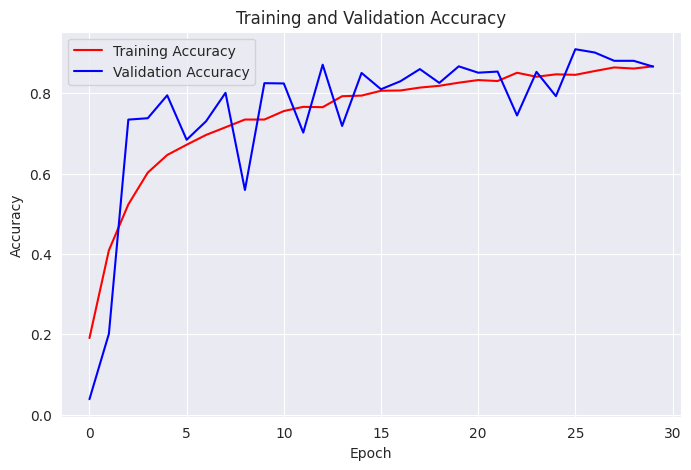

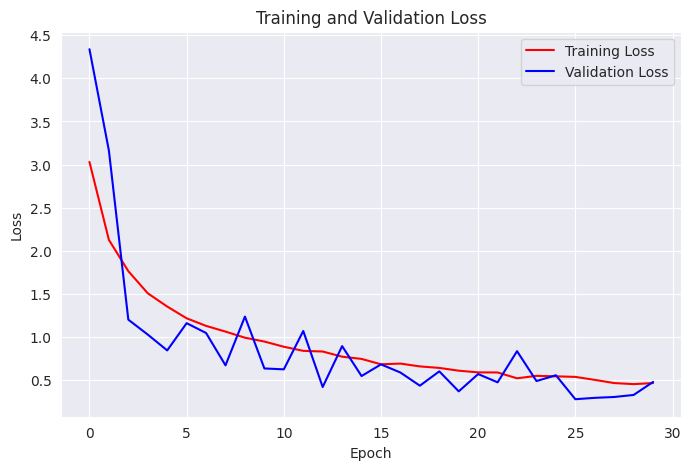

In [ ]:
import matplotlib.pyplot as plt

# Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# *Evaluation*

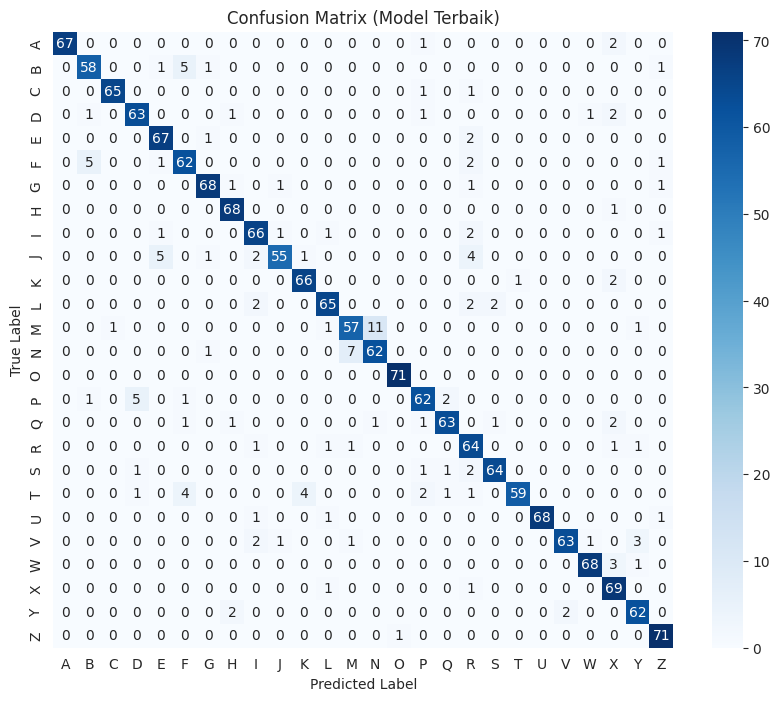


Classification Report (Model Terbaik):

              precision    recall  f1-score   support

           A     1.0000    0.9571    0.9781        70
           B     0.8923    0.8788    0.8855        66
           C     0.9848    0.9701    0.9774        67
           D     0.9000    0.9130    0.9065        69
           E     0.8933    0.9571    0.9241        70
           F     0.8493    0.8732    0.8611        71
           G     0.9444    0.9444    0.9444        72
           H     0.9315    0.9855    0.9577        69
           I     0.8919    0.9167    0.9041        72
           J     0.9483    0.8088    0.8730        68
           K     0.9296    0.9565    0.9429        69
           L     0.9286    0.9155    0.9220        71
           M     0.8636    0.8028    0.8321        71
           N     0.8378    0.8857    0.8611        70
           O     0.9861    1.0000    0.9930        71
           P     0.8986    0.8732    0.8857        71
           Q     0.9403    0.9000    0.9

In [ ]:
# Asumsi Anda telah menyimpan model terbaik ke 'best_model.h5' selama pelatihan
best_model = load_model('best_model.h5')

# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi probabilitas menggunakan model terbaik
preds = best_model.predict(test_generator, verbose=0)

# Ambil prediksi kelas (argmax)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=class_labels, columns=class_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Model Terbaik)')
plt.show()

# Classification Report
print("\nClassification Report (Model Terbaik):\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# *Simpan model*

In [ ]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-05-25 10:11:53.683356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748167913.702984   43973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748167913.709001   43973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-25 10:11:59.797350: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748167919.797509   43973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
from google.colab import files
import shutil

# Kompres folder model TFJS ke zip
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

# Download model TFJS
files.download('/content/tfjs_model.zip')

# Juga download versi SavedModel (kalau perlu)
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')
files.download('/content/saved_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# *Inference:*

## *Menggunakan best_modek*

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


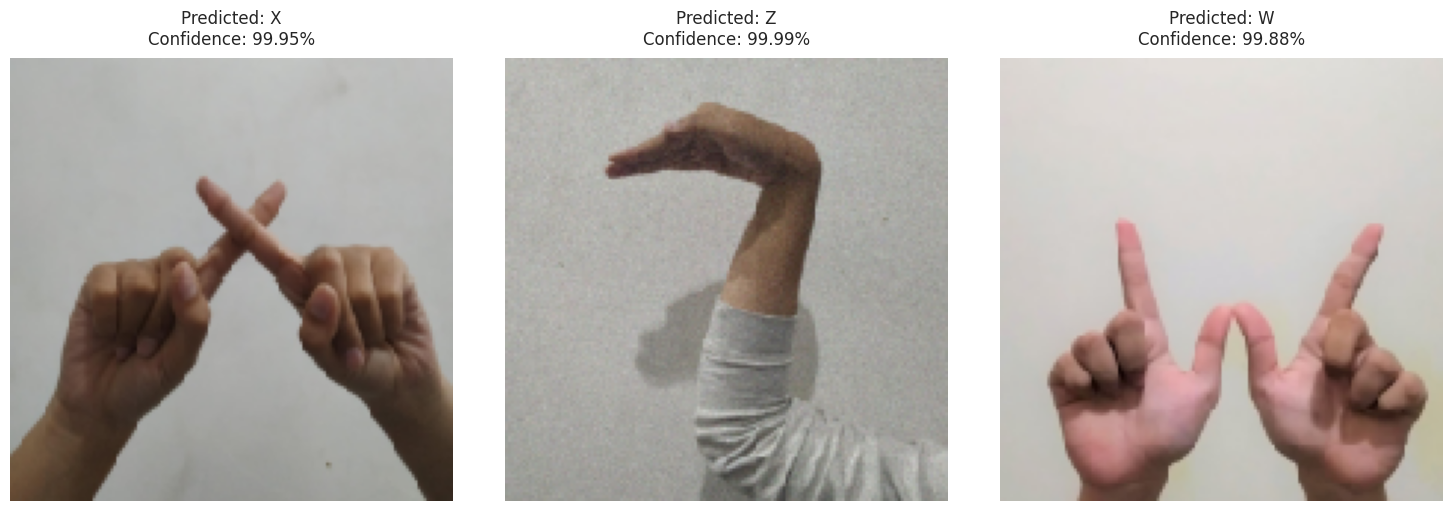

In [ ]:
# Load Model
model = load_model('best_model.h5')

# Daftar Class
class_names = list(train_generator.class_indices.keys())

# 3. Fungsi Preprocessing
def preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# List Gambar yang Akan Diprediksi
image_paths = [
    '/content/Screenshot 2025-05-25 185947.png',
    '/content/Screenshot 2025-05-25 185955.png',
    '/content/Screenshot 2025-05-25 190002.png'
]

# Prediksi + Visualisasi
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_paths):
    # Preprocess
    processed_img = preprocess_image(img_path)

    # Prediksi
    pred = model.predict(processed_img)
    predicted_class = np.argmax(pred, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(pred) * 100

    # Tampilkan Gambar + Hasil
    plt.subplot(1, len(image_paths), i+1)
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%", pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()